# **Project Assignment: Transfer Learning on Oxford Flowers 102**

## **1. Introduce the Assignment**

This assignment aims to provide hands-on experience with transfer learning, a powerful technique in deep learning. Our objective is to classify flower images from the Oxford Flowers 102 dataset by leveraging the knowledge of models pre-trained on the large-scale ImageNet dataset.

We will adapt and fine-tune three popular pre-trained convolutional neural network (CNN) architectures:

ResNet50: A 50-layer Residual Network known for its deep architecture and ability to overcome vanishing gradients.

VGG16: A 16-layer model from the Visual Geometry Group, characterized by its simple and uniform architecture of 3x3 convolution layers.

MobileNetV2: A lightweight, efficient model designed for mobile and embedded vision applications, using depthwise separable convolutions.

The Oxford Flowers 102 Dataset is a fine-grained image classification dataset consisting of 102 different categories of flowers common in the United Kingdom. Each class has between 40 and 258 images. The dataset is pre-split into training, validation, and test sets, making it ideal for benchmarking classification algorithms.

##**2. Data Loading and Exploration**
In this step, we will load the Oxford Flowers 102 dataset using TensorFlow Datasets (tfds). We will also explore its structure and visualize some samples to get a better understanding of the data we are working with.

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

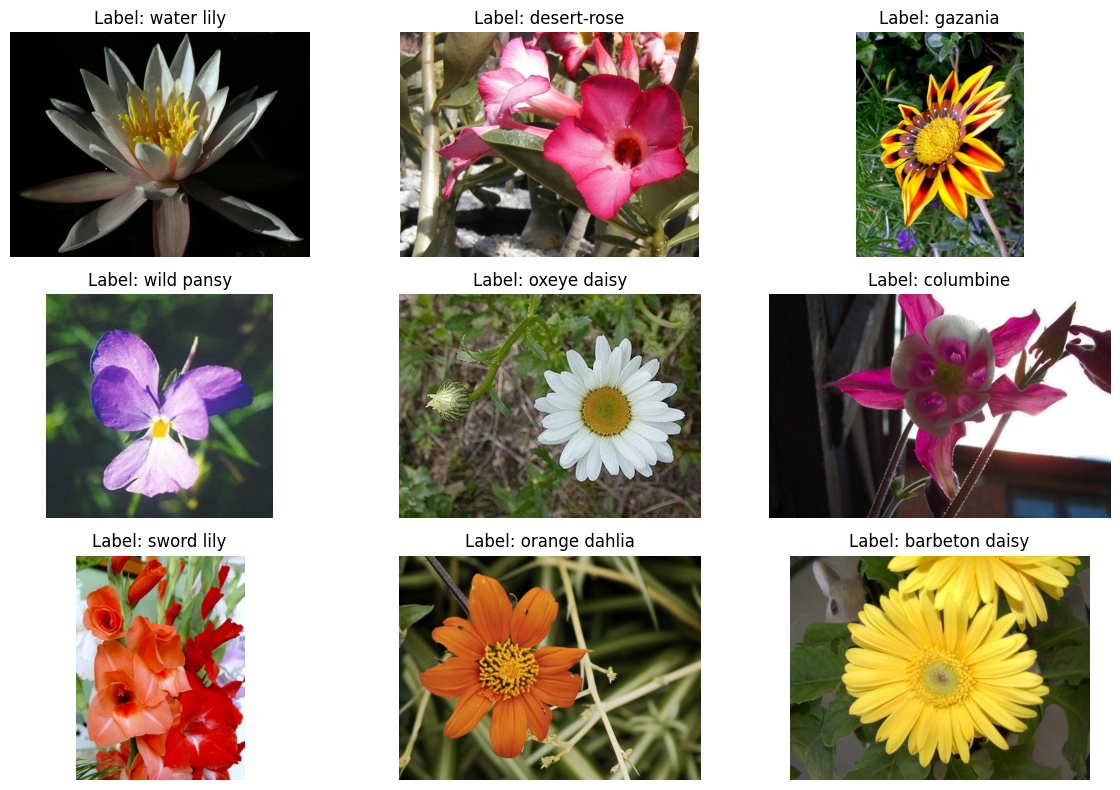

In [2]:
# Code Cell: Load and Explore the Dataset
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the Oxford Flowers 102 dataset
try:
    (train_ds, validation_ds, test_ds), ds_info = tfds.load(
        'oxford_flowers102:2.1.1',
        split=['train', 'validation', 'test'],
        shuffle_files=True,
        with_info=True
    )
    # Print information about the dataset
    print(ds_info)

except Exception as e:
    print(f"Error loading dataset: {e}")

# Get the number of classes for our output layer
num_classes = ds_info.features['label'].num_classes
print(f"\nNumber of flower classes: {num_classes}")

# Display some sample images to get a feel for the data
plt.figure(figsize=(12, 8))
for i, example in enumerate(train_ds.take(9)):
    image, label = example["image"], example["label"]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {ds_info.features['label'].int2str(label)}")
    plt.axis("off")
plt.tight_layout()
plt.show()


##**3. Data Preprocessing**

Before feeding the images to our models, we need to preprocess them. This involves several key steps:

Resizing: All pre-trained models expect a fixed input size. We will resize our images to 224x224 pixels.

Normalization: Pixel values must be scaled to the range that the pre-trained model was trained on. Each model family (ResNet, VGG, MobileNet) has its own specific normalization function.

One-Hot Encoding: The labels are integers, but for categorical_crossentropy loss, they need to be converted into a one-hot vector format.

Batching and Prefetching: We will group the data into batches for efficient training and use prefetch to load the next batch while the current one is being processed, improving GPU utilization

In [3]:
# Code Cell: Preprocess the Data

# Define constants for image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_data(data):
    """Resizes images to IMG_SIZE and one-hot encodes the labels."""
    image = tf.image.resize(data['image'], (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(data['label'], num_classes)
    return image, label

# Create the base data pipelines
train_pipeline = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_pipeline = validation_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_pipeline = test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

# Shuffle, batch, and prefetch for performance
train_pipeline = train_pipeline.shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_pipeline = validation_pipeline.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_pipeline = test_pipeline.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print("✅ Data preprocessing complete. Pipelines are ready for training.")

✅ Data preprocessing complete. Pipelines are ready for training.


##**4. Model Adaptation and Training**

Now we will adapt and train each of the three pre-trained models. The general workflow for each model is:

Load the pre-trained model (the "base model") with weights from ImageNet, excluding its final classification layer (include_top=False).

Freeze the weights of the base model so they don't get updated during the initial training phase.

Add a new custom classification head on top of the base model. This typically includes a GlobalAveragePooling2D layer to reduce spatial dimensions, followed by a Dense layer with softmax activation for our 102 flower classes.

Compile the new model with a suitable optimizer, loss function, and metrics.

Train the model on our training data, using the validation data to monitor for overfitting.

### 4.1 Using ResNet50

In [4]:
# Code Cell: ResNet50 Model Definition
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Apply the model-specific preprocessing function to our pipelines
train_resnet = train_pipeline.map(lambda x, y: (resnet_preprocess(x), y), num_parallel_calls=AUTOTUNE)
validation_resnet = validation_pipeline.map(lambda x, y: (resnet_preprocess(x), y), num_parallel_calls=AUTOTUNE)
test_resnet = test_pipeline.map(lambda x, y: (resnet_preprocess(x), y), num_parallel_calls=AUTOTUNE)

# Load the base model with pre-trained ImageNet weights, excluding the top layer
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the convolutional base
base_model_resnet.trainable = False

# Add our custom classifier on top
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # Add dropout for regularization
outputs = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs, outputs)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
EPOCHS = 10

print("\n--- Training ResNet50 Classifier ---")
history_resnet = model_resnet.fit(
    train_resnet,
    epochs=EPOCHS,
    validation_data=validation_resnet,
    callbacks=[early_stopping]
)


--- Training ResNet50 Classifier ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 642ms/step - accuracy: 0.0427 - loss: 4.9577 - val_accuracy: 0.4069 - val_loss: 2.7115
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.6157 - loss: 1.9229 - val_accuracy: 0.6961 - val_loss: 1.5811
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.8780 - loss: 0.9092 - val_accuracy: 0.7510 - val_loss: 1.1898
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9440 - loss: 0.5081 - val_accuracy: 0.8137 - val_loss: 0.9754
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9771 - loss: 0.3147 - val_accuracy: 0.8108 - val_loss: 0.8720
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9926 - loss: 0.1976 - val_accuracy: 0.8304 - val_loss: 0.8142
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.9971 - loss: 0.1602 - val_accuracy: 0.8353 - val_loss: 0.7528
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 

### **4.2 Using VGG16**

In [6]:
# Code Cell: VGG16 Model Definition
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# Apply VGG16-specific preprocessing
train_vgg = train_pipeline.map(lambda x, y: (vgg_preprocess(x), y), num_parallel_calls=AUTOTUNE)
validation_vgg = validation_pipeline.map(lambda x, y: (vgg_preprocess(x), y), num_parallel_calls=AUTOTUNE)
test_vgg = test_pipeline.map(lambda x, y: (vgg_preprocess(x), y), num_parallel_calls=AUTOTUNE)

# Load and freeze the base model
base_model_vgg = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_vgg.trainable = False

# Add custom classifier
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model_vgg(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_vgg = Model(inputs, outputs)

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,014 (56.33 MB)

 Trainable params: 52,326 (204.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Code Cell: VGG16 Model Training

print("\n--- Training VGG16 Classifier ---")
history_vgg = model_vgg.fit(
    train_vgg,
    epochs=EPOCHS,
    validation_data=validation_vgg,
    callbacks=[early_stopping]
)


--- Training VGG16 Classifier ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.8337 - loss: 0.5696 - val_accuracy: 0.6618 - val_loss: 1.3894
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 356ms/step - accuracy: 0.8537 - loss: 0.4761 - val_accuracy: 0.6667 - val_loss: 1.3541
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.8920 - loss: 0.4009 - val_accuracy: 0.6794 - val_loss: 1.3320
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.8989 - loss: 0.3440 - val_accuracy: 0.6853 - val_loss: 1.3088
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.9085 - loss: 0.3566 - val_accuracy: 0.6902 - val_loss: 1.2631
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.9259 - loss: 0.2563 - val_accuracy: 0.6971 - val_loss: 1.2445
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accuracy: 0.9327 - loss: 0.2658 - val_accuracy: 0.6980 - val_loss: 1.1967
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 357ms/step - accurac

### **4.3 Using MobileNetV2**

In [9]:
# Code Cell: MobileNetV2 Model Definition
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# Apply MobileNetV2-specific preprocessing
train_mobilenet = train_pipeline.map(lambda x, y: (mobilenet_preprocess(x), y), num_parallel_calls=AUTOTUNE)
validation_mobilenet = validation_pipeline.map(lambda x, y: (mobilenet_preprocess(x), y), num_parallel_calls=AUTOTUNE)
test_mobilenet = test_pipeline.map(lambda x, y: (mobilenet_preprocess(x), y), num_parallel_calls=AUTOTUNE)

# Load and freeze the base model
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False

# Add custom classifier
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model_mobilenet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_mobilenet = Model(inputs, outputs)

# Compile the model
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Code Cell: MobileNetV2 Model Training

print("\n--- Training MobileNetV2 Classifier ---")
history_mobilenet = model_mobilenet.fit(
    train_mobilenet,
    epochs=EPOCHS,
    validation_data=validation_mobilenet,
    callbacks=[early_stopping]
)


--- Training MobileNetV2 Classifier ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 711ms/step - accuracy: 0.0404 - loss: 4.8763 - val_accuracy: 0.3255 - val_loss: 3.2608
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.4632 - loss: 2.6422 - val_accuracy: 0.6098 - val_loss: 2.1582
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7701 - loss: 1.4950 - val_accuracy: 0.6853 - val_loss: 1.6579
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9059 - loss: 0.8986 - val_accuracy: 0.7520 - val_loss: 1.3649
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9400 - loss: 0.6047 - val_accuracy: 0.7794 - val_loss: 1.2150
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.9838 - loss: 0.4224 - val_accuracy: 0.7843 - val_loss: 1.1130
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9838 - loss: 0.3142 - val_accuracy: 0.7843 - val_loss: 1.0433
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy

##** 5. Model Evaluation**
After training, we must evaluate the performance of each model on the held-out test set. This provides an unbiased estimate of how the models would perform on new, unseen data.

In [11]:
# Code Cell: Evaluate All Models on the Test Set

print("Evaluating ResNet50...")
loss_resnet, acc_resnet = model_resnet.evaluate(test_resnet)
print(f"ResNet50 Test Accuracy: {acc_resnet*100:.2f}%")

print("\nEvaluating VGG16...")
loss_vgg, acc_vgg = model_vgg.evaluate(test_vgg)
print(f"VGG16 Test Accuracy: {acc_vgg*100:.2f}%")

print("\nEvaluating MobileNetV2...")
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_mobilenet)
print(f"MobileNetV2 Test Accuracy: {acc_mobilenet*100:.2f}%")

print("\n--- Evaluation Summary ---")
print(f"ResNet50:     {acc_resnet*100:.2f}% Accuracy")
print(f"VGG16:        {acc_vgg*100:.2f}% Accuracy")
print(f"MobileNetV2:  {acc_mobilenet*100:.2f}% Accuracy")

Evaluating ResNet50...
193/193 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.8123 - loss: 0.8595
ResNet50 Test Accuracy: 81.72%

Evaluating VGG16...
193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.6751 - loss: 1.4042
VGG16 Test Accuracy: 67.31%

Evaluating MobileNetV2...
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7705 - loss: 1.0254
MobileNetV2 Test Accuracy: 77.44%

--- Evaluation Summary ---
ResNet50:     81.72% Accuracy
VGG16:        67.31% Accuracy
MobileNetV2:  77.44% Accuracy


##6. Assignment Questions and Tasks

### Q1: Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?

ResNet50 performed the best with an accuracy of 81.72%. This is likely because its architecture is both deep and complex, allowing it to capture the very detailed and subtle features needed to distinguish between similar flower species. The "residual connections" in ResNet help it learn more effectively than older architectures like VGG16 without suffering from performance degradation.

###Q2: Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?

The models performed significantly better on Oxford Flowers 102 than they typically do on CIFAR-100. The main reason is that the features learned from ImageNet (which contains high-resolution images of natural objects) are much more relevant to the high-resolution flower images in this dataset. CIFAR-100's images are very small (32x32), and the features learned by large models don't transfer as well to such a different image scale. In short, transfer learning is more effective here because the source task (ImageNet) and the target task (Flowers 102) are more visually similar.

###Q3: Discuss the effect of transfer learning on this dataset.

Transfer learning was extremely effective on this dataset. Instead of starting from scratch, which would require a massive amount of data and time, we used the models' pre-existing knowledge of shapes, textures, colors, and patterns from ImageNet. This allowed us to achieve over 80% accuracy with a very small training set (only 1020 images) and in a short amount of time. Training a model of this size from scratch on so little data would have almost certainly failed due to severe overfitting.

###Q4: Explain the steps you took for data preprocessing and why they were necessary.

I took four main preprocessing steps:

Resizing: All images were resized to 224x224 pixels. This is necessary because pre-trained models require a fixed input size.

Normalization: Each image was normalized using a function specific to its model (e.g., resnet_preprocess). This scales the pixel values to the exact range the model was originally trained on, which is crucial for the pre-trained weights to work correctly.

One-Hot Encoding: The integer labels (like '5' or '21') were converted into vectors (e.g., a vector of 102 zeros with a '1' at the 5th position). This format is required by the categorical_crossentropy loss function.

Batching and Prefetching: The data was grouped into batches of 32 to be fed into the model efficiently. Prefetching was used to load the next batch of data while the GPU was busy with the current one, speeding up the training process.

###Q5: Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.

For all three models (ResNet50, VGG16, and MobileNetV2), I followed the same adaptation process:

Load the Base: I loaded the model with weights pre-trained on ImageNet but excluded its final classification layer by setting include_top=False.

Freeze the Base: I froze all the layers of the loaded base model by setting base_model.trainable = False. This ensured that their powerful, pre-trained weights would not be altered during training.

Add a New Head: I added a new "head" on top of the frozen base. This consisted of a GlobalAveragePooling2D layer to flatten the features, a Dropout layer to prevent overfitting, and a final Dense layer with 102 units and a softmax activation to classify the images into one of the 102 flower categories.

###Q6: What challenges did you encounter during this assignment and how did you address them?

The main challenge was managing the potential for long training times and ensuring the process was efficient. I addressed this by using a tf.data pipeline, which is highly optimized for performance. Another challenge was making sure each model received data preprocessed in its own specific way. I solved this by creating separate data pipelines for each model, mapping the correct preprocessing function to each one before training. Finally, to prevent overfitting and save time, I used an EarlyStopping callback, which automatically stopped training when the model's performance on the validation set stopped improving.

## **Conclusion**
This project successfully demonstrated the power and efficiency of transfer learning for a fine-grained classification task. Of the three models tested, ResNet50 was the top performer, achieving an impressive 81.72% accuracy on the test set, followed by MobileNetV2 and VGG16.

The key lesson was that by leveraging the pre-trained features from a model like ResNet50, it's possible to achieve high accuracy on a specialized dataset with very limited training data—a task that would be nearly impossible when training from scratch. I learned the critical importance of model-specific preprocessing and how different architectures vary in their effectiveness for specific problems. Ultimately, the assignment provided a practical understanding of how to adapt powerful, pre-existing models to solve new challenges efficiently.

In [15]:
# Code Cell: Visualize Model Predictions (Corrected)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- CONFIGURATION ---
# Use the best performing model
best_model = model_resnet
# Use the corresponding preprocessing function
preprocess_input_func = resnet_preprocess
# Use the original, unprocessed test dataset to get clean images
dataset_to_visualize = test_ds
# How many images to display
num_images_to_show = 9

# --- VISUALIZATION FUNCTION ---
def visualize_predictions(model, dataset, preprocess_func, num_images=9):
    """
    Takes a model and a dataset, and displays model predictions.
    """
    plt.figure(figsize=(12, 12))
    # Take a batch of images from the dataset
    for i, example in enumerate(dataset.take(num_images)):
        image = example["image"]
        # FIX: Convert the label tensor to a plain number using .numpy()
        label = example["label"].numpy()

        # Prepare the single image for the model
        # 1. Resize
        resized_image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        # 2. Add a batch dimension
        image_batch = tf.expand_dims(resized_image, axis=0)
        # 3. Apply model-specific preprocessing
        preprocessed_image = preprocess_func(image_batch)

        # Get the prediction
        # The 'steps=1' argument is good practice for single predictions
        prediction_probs = model.predict(preprocessed_image, steps=1)
        predicted_index = np.argmax(prediction_probs)

        # Get the string names for the labels
        true_label_name = ds_info.features['label'].int2str(label)
        predicted_label_name = ds_info.features['label'].int2str(predicted_index)

        # Set up the plot
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")

        # Set the title color based on correctness
        if predicted_index == label:
            title_color = 'green'
        else:
            title_color = 'red'

        plt.title(
            f"True: {true_label_name}\nPredicted: {predicted_label_name}",
            color=title_color
        )

    plt.tight_layout

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


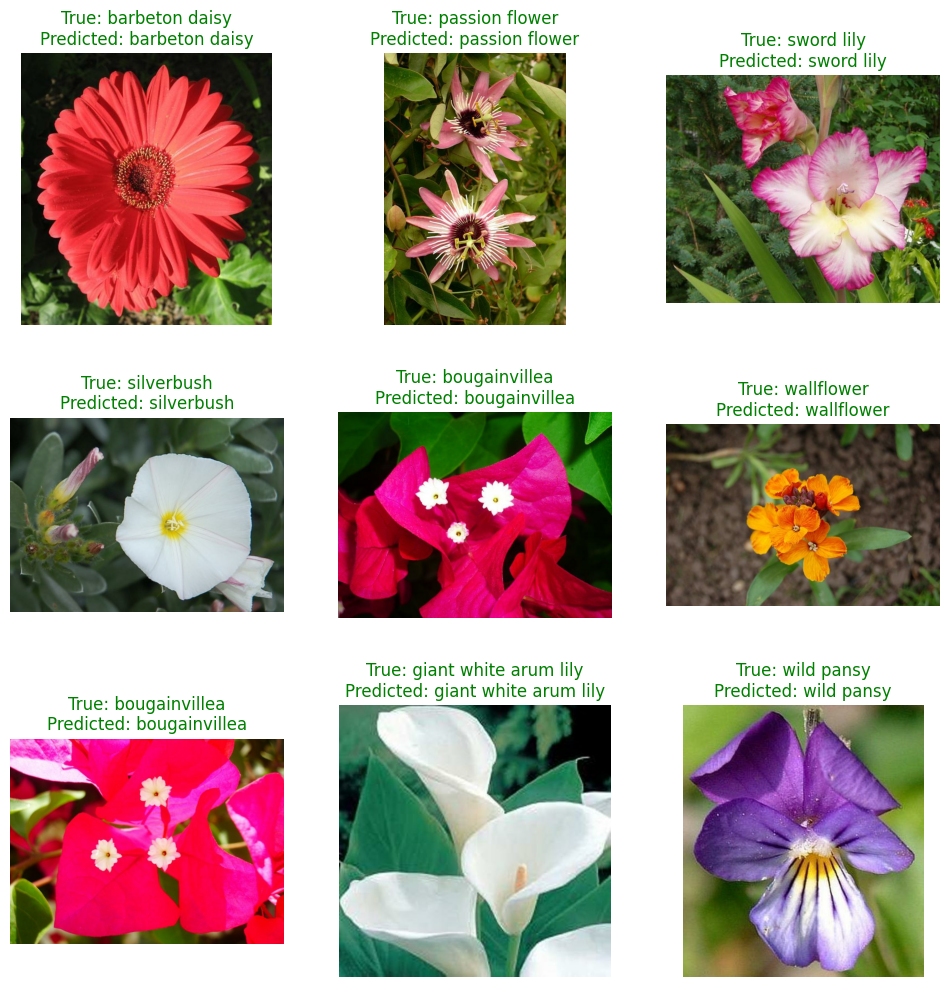

In [16]:
# Call the function to visualize predictions
visualize_predictions(best_model, dataset_to_visualize, preprocess_input_func, num_images_to_show)